In [1]:
import mlflow
import mlflow.sklearn
#import pandas as pd
#import matplotlib.pyplot as plt
from numpy import savetxt
#from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV, train_test_split
from pprint import pprint
import pandas as pd
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from mlflow import log_metric, log_param, log_artifacts
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, get_scorer_names, accuracy_score,confusion_matrix, roc_curve
from sklearn.preprocessing import OneHotEncoder
import joblib
import pickle

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

#from sklearn.metrics import mean_squared_error

### Metodos para log

In [2]:

#from utils import fetch_logged_data

def yield_artifacts(run_id, path=None):
    """Yield all artifacts in the specified run"""
    client = mlflow.tracking.MlflowClient()
    for item in client.list_artifacts(run_id, path):
        if item.is_dir:
            yield from yield_artifacts(run_id, item.path)
        else:
            yield item.path


def fetch_logged_data(run_id):
    """Fetch params, metrics, tags, and artifacts in the specified run"""
    client = mlflow.tracking.MlflowClient()
    data = client.get_run(run_id).data
    # Exclude system tags: https://www.mlflow.org/docs/latest/tracking.html#system-tags
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = list(yield_artifacts(run_id))
    return {
        "params": data.params,
        "metrics": data.metrics,
        "tags": tags,
        "artifacts": artifacts,
    }



# V5 anomalias

In [22]:


fraudes_df = pd.read_csv('data_final_3.csv').drop(['grupo'],axis=1)#.drop(['LOCALIDAD','MUNICIPIO'], axis = 1)
len(fraudes_df)

45306

In [3]:
fraudes_df = pd.read_csv('datos_regiones_especiales_201906-202205.csv').drop(['grupo','NombreRegion'],axis=1)#.drop(['LOCALIDAD','MUNICIPIO'], axis = 1)
#fraudes_df = pd.merge(fraudes_df, actividad_econ_df,how='inner', on = ['nis_rad']).drop('Unnamed: 0', axis=1)
fraudes_df.head()

,LlavePuntoConsumo,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,202204,202205,AlturaPuntoConsumo,NombreDepartamentoGeografia,NombreMunicipioGeografia,seccion,DescripcionAnomalia,anomalias_anuales,fraude
0,1002467,122.72,111.53,113.11,97.14,102.40,95.17,121.67,125.47,133.44,114.80,124.71,123.69,1784.0,CHIMALTENANGO,CHIMALTENANGO,Residenciales,NO REGSITRADO,0,1
1,1017184,0.00,3.15,10.46,114.57,1.01,1.90,1.05,0.95,0.00,0.00,0.00,0.00,1779.0,CHIMALTENANGO,SAN MARTIN JILOTEPEQUE,Residenciales,Presunto Fraude,0,1
2,2405770,111.18,147.18,161.90,236.47,344.72,323.79,90.20,81.74,122.65,171.71,270.71,245.36,2530.0,SOLOLA,SANTA LUCIA UTATLAN,Residenciales,NO REGSITRADO,0,1
3,2442128,58.87,62.93,94.19,294.35,227.11,207.21,205.57,212.92,238.58,219.00,255.50,208.99,2033.0,QUICHE,SANTA CRUZ DEL QUICHE,Residenciales,NO REGSITRADO,0,1
4,3161851,25.51,13.64,2.94,11.41,11.54,13.31,23.07,27.57,39.25,37.51,42.58,41.21,921.0,SANTA ROSA,CUILAPA,Residenciales,Tapa rota/falta,0,1


In [20]:
X.head()

,LlavePuntoConsumo,202106,202107,202108,202109,202110,202111,202112,202201,202202,...,DescripcionAnomalia_Medidor en poder del Cliente,DescripcionAnomalia_Medidor interno sin acceso,DescripcionAnomalia_Medidor muy alto,DescripcionAnomalia_NO REGSITRADO,DescripcionAnomalia_Num.med. no coincide,DescripcionAnomalia_Numero de Medidor c/Dem. no Coincide,DescripcionAnomalia_Observaciones,DescripcionAnomalia_Presunto Fraude,DescripcionAnomalia_Presunto Fraude > 11kW,DescripcionAnomalia_Tapa rota/falta
0,3052515,129.27,124.52,101.39,120.65,132.46,122.65,95.45,94.02,84.15,...,0,0,0,1,0,0,0,0,0,0
1,5880480,71.32,71.63,59.82,67.49,51.02,54.54,51.02,53.74,70.97,...,0,0,0,1,0,0,0,0,0,0
2,6631486,3.15,1.01,1.96,1.96,3.80,4.20,2.10,0.98,3.92,...,0,0,0,1,0,0,0,0,0,0
3,2320981,11.95,11.41,12.17,13.18,15.70,13.74,13.64,13.31,12.76,...,0,0,0,1,0,0,0,0,0,0
4,5839450,114.06,66.72,67.70,67.93,58.93,62.86,52.44,52.28,61.85,...,0,0,0,1,0,0,0,0,0,0


In [5]:
len(fraudes_df)

4645

In [25]:
fraudes_df.columns

Index(['LlavePuntoConsumo', '202106', '202107', '202108', '202109', '202110',
       '202111', '202112', '202201', '202202', '202203', '202204', '202205',
       'AlturaPuntoConsumo', 'NombreDepartamentoGeografia',
       'NombreMunicipioGeografia', 'seccion', 'DescripcionAnomalia', 'fraude'],
      dtype='object')

### Encoder

In [23]:
ohe_features = fraudes_df


In [ ]:
ohe_NombreDepartamentoGeografia = OneHotEncoder(handle_unknown = 'ignore')
ohe_NombreMunicipioGeografia = OneHotEncoder(handle_unknown = 'ignore')
ohe_seccion = OneHotEncoder(handle_unknown = 'ignore')
ohe_DescripcionAnomalia = OneHotEncoder(handle_unknown = 'ignore')

transformed_NombreDepartamentoGeografia = ohe_NombreDepartamentoGeografia.fit_transform(ohe_features[['NombreDepartamentoGeografia']])
ohe_features[ohe_NombreDepartamentoGeografia.categories_[0]] = transformed_NombreDepartamentoGeografia.toarray()

transformed_NombreMunicipioGeografia = ohe_NombreMunicipioGeografia.fit_transform(ohe_features[['NombreMunicipioGeografia']])
ohe_features[ohe_NombreMunicipioGeografia.categories_[0]] = transformed_NombreMunicipioGeografia.toarray()

transformed_seccion = ohe_seccion.fit_transform(ohe_features[['seccion']])
ohe_features[ohe_seccion.categories_[0]] = transformed_seccion.toarray()

transformed_DescripcionAnomalia = ohe_DescripcionAnomalia.fit_transform(ohe_features[['DescripcionAnomalia']])
ohe_features[ohe_DescripcionAnomalia.categories_[0]] = transformed_DescripcionAnomalia.toarray()

ohe_features = ohe_features.drop(['NombreDepartamentoGeografia','NombreMunicipioGeografia','seccion','DescripcionAnomalia'], axis = 1)

In [ ]:
len(scaled_features.columns)

In [ ]:
for x in ohe_features.columns:
    print(x)

In [8]:
ohe_features.head()

,LlavePuntoConsumo,202106,202107,202108,202109,202110,202111,202112,202201,202202,...,Medidor interno sin acceso,Medidor muy alto,Medidor o caja opaca,NO REGSITRADO,Num.med. no coincide,Numero de Medidor c/Dem. no Coincide,Observaciones,Presunto Fraude,Tapa rota/falta,Vidrio Med. sin marchamo
0,1002467,122.72,111.53,113.11,97.14,102.40,95.17,121.67,125.47,133.44,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1017184,0.00,3.15,10.46,114.57,1.01,1.90,1.05,0.95,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2405770,111.18,147.18,161.90,236.47,344.72,323.79,90.20,81.74,122.65,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2442128,58.87,62.93,94.19,294.35,227.11,207.21,205.57,212.92,238.58,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3161851,25.51,13.64,2.94,11.41,11.54,13.31,23.07,27.57,39.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [26]:
len(ohe_features)

45306

<AxesSubplot:>

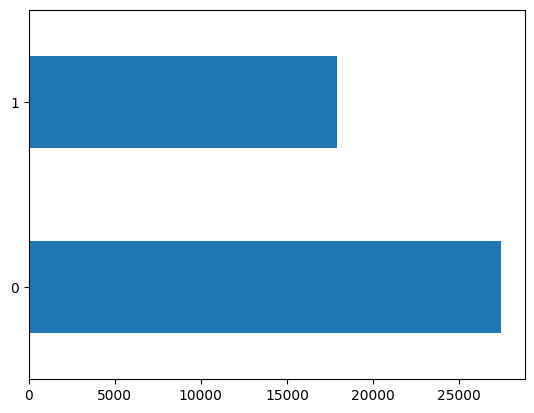

In [32]:
ohe_features['fraude'].value_counts().plot(kind = 'barh')

In [33]:
y = ohe_features['fraude']

X = ohe_features



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.drop(['fraude','LlavePuntoConsumo'], axis = 1)

nis_x_test = X_test['LlavePuntoConsumo']

X_test = X_test.drop(['fraude','LlavePuntoConsumo'], axis = 1)
                      
X_test_full = X_test

In [34]:
y_train.value_counts()

0    21949
1    14295
Name: fraude, dtype: int64

In [35]:
y_test.value_counts()

0    5476
1    3586
Name: fraude, dtype: int64

In [ ]:
def main():
    mlflow.set_experiment(experiment_name="test-deeps")
    mlflow.sklearn.autolog()

    f1sc = make_scorer(f1_score, average='binary')
    rcsc = make_scorer(recall_score)
   
    #180 modelos entrenados 
    #parameters = {"n_jobs":[-1], "n_estimators": [200,400], "max_features": ('sqrt','log2')}

    #parameters = {"n_jobs":[-1], "n_estimators": [200,400,800,1000], \
            #      "max_features": ['sqrt','log2'], "max_depth": [None,15,30,50,80,100], "criterion": ['gini','entropy'], "min_samples_leaf": [1,3,5]}
   
    parameters = {"n_jobs":[-1], "n_estimators": [130,190,400], \
                  "max_features": ['sqrt','log2'], "max_depth": [25], "criterion": ['gini','entropy'], "min_samples_leaf": [1,3,5]}
    
    rfc = RandomForestClassifier()
    clf = GridSearchCV(rfc, parameters, cv = 5,verbose=1)

    clf.fit(X_train.values, y_train.values)
    run_id = mlflow.last_active_run().info.run_id

    # show data logged in the parent run
    print("========== parent run ==========")
    for key, data in fetch_logged_data(run_id).items():
        print("\n---------- logged {} ----------".format(key))
        pprint(data)
        
    #mlflow.log_metric("mi_metrica", clf.best_score_)
    
   # log_metric("mi_metrica3", clf.best_score_)

    # show data logged in the child runs
    filter_child_runs = "tags.mlflow.parentRunId = '{}'".format(run_id)
    runs = mlflow.search_runs(filter_string=filter_child_runs)
    param_cols = ["params.{}".format(p) for p in parameters.keys()]
    metric_cols = ["metrics.mean_test_score"]

    print("\n========== child runs ==========\n")
    pd.set_option("display.max_columns", None)  # prevent truncating columns
    print(runs[["run_id", *param_cols, *metric_cols]])
    
    with mlflow.start_run(run_id=run_id) as run:
        print('---TEST_METRICS----')
        
        y_pred = clf.predict(X_test.values)
        y_true = y_test.values
        print(y_pred)
        print(y_true)
        f1 = f1_score(y_true, y_pred, average='binary')
        log_metric("test_f1_score", f1)
        print('test_score_f1 '+str(f1))
        recall = recall_score(y_true, y_pred, average='binary')
        log_metric("test_recall_score", recall)
        print('test_recall_f1 '+str(recall))
        accuracy = accuracy_score(y_true, y_pred)
        log_metric("test_accuracy_score", accuracy)
        print('test_score_accuracy '+str(accuracy))
        precision = precision_score(y_true, y_pred)
        log_metric("test_precision_score", precision)
        print('test_score_precision '+str(precision))
    
        test_cfm = confusion_matrix(y_true, y_pred)
        df_cfm = pd.DataFrame(test_cfm, index = ["0", "1"], columns = ["0", "1"])
        plt.figure(figsize = (10,7))
        cfm_plot = sn.heatmap(df_cfm, annot=True)
        cfm_plot.figure.savefig("cfm_test.png")
        print(test_cfm)
        mlflow.log_artifact("cfm_test.png")
if __name__ == "__main__":
    main()

Feature: 0, Score: 0.05080
Feature: 1, Score: 0.04915
Feature: 2, Score: 0.04833
Feature: 3, Score: 0.04586
Feature: 4, Score: 0.04777
Feature: 5, Score: 0.04918
Feature: 6, Score: 0.04961
Feature: 7, Score: 0.04770
Feature: 8, Score: 0.04968
Feature: 9, Score: 0.05618
Feature: 10, Score: 0.05144
Feature: 11, Score: 0.06027
Feature: 12, Score: 0.06717
Feature: 13, Score: 0.02589
Feature: 14, Score: 0.00378
Feature: 15, Score: 0.01337
Feature: 16, Score: 0.00024
Feature: 17, Score: 0.00070
Feature: 18, Score: 0.00248
Feature: 19, Score: 0.00354
Feature: 20, Score: 0.00004
Feature: 21, Score: 0.00537
Feature: 22, Score: 0.00003
Feature: 23, Score: 0.01324
Feature: 24, Score: 0.00175
Feature: 25, Score: 0.00003
Feature: 26, Score: 0.00026
Feature: 27, Score: 0.00125
Feature: 28, Score: 0.00242
Feature: 29, Score: 0.00114
Feature: 30, Score: 0.00232
Feature: 31, Score: 0.00033
Feature: 32, Score: 0.00133
Feature: 33, Score: 0.00053
Feature: 34, Score: 0.00178
Feature: 35, Score: 0.00050
Fe

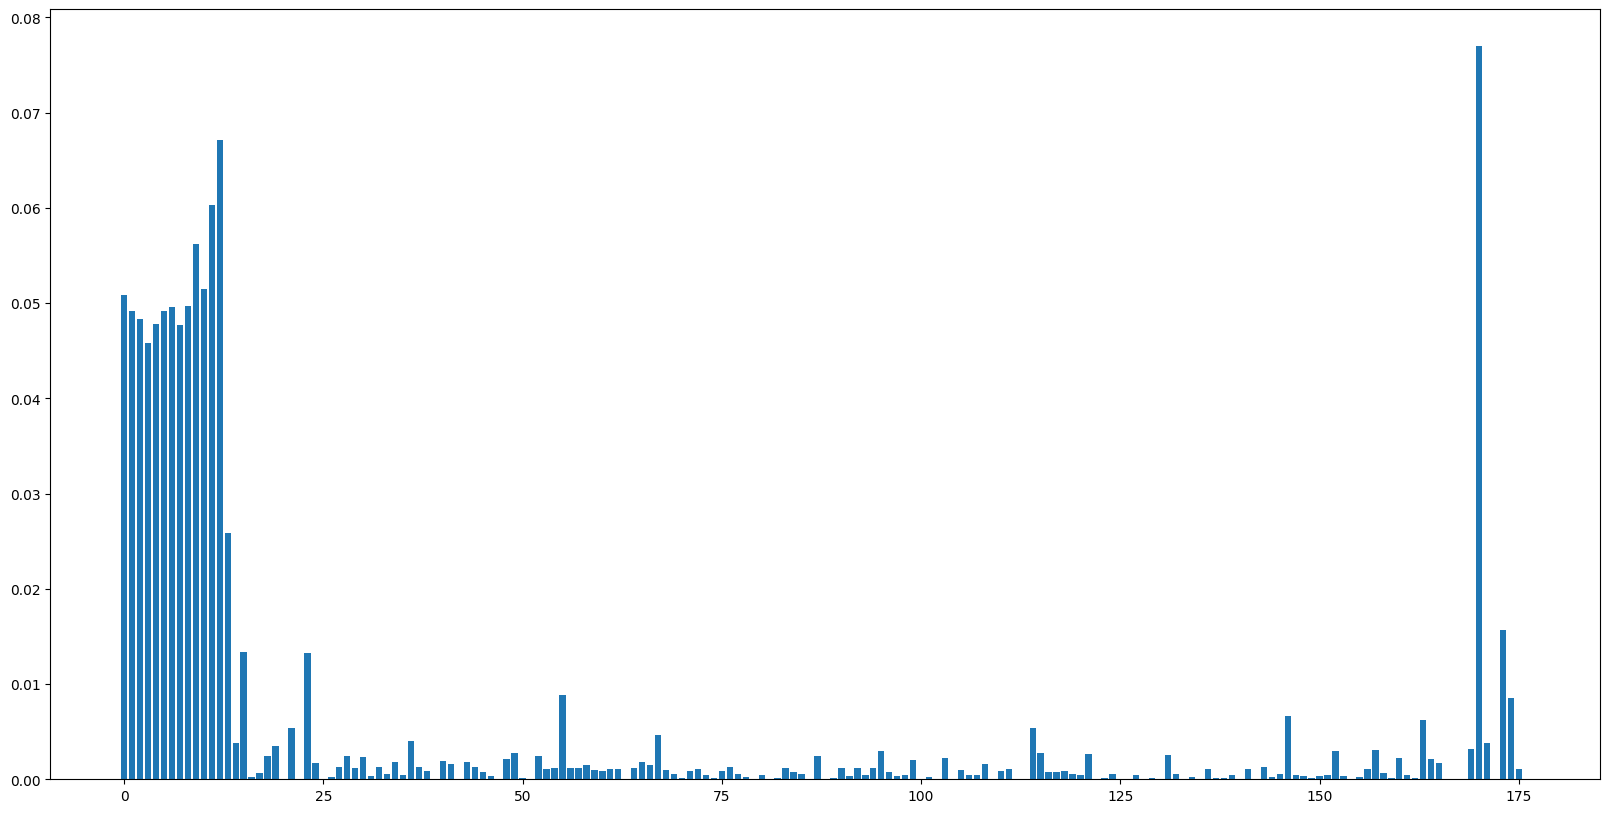

In [4]:
from matplotlib import pyplot
model = joblib.load('./mlruns/5/0c14ca5459e34eea875b7014e4b00a92/artifacts/best_estimator/model.pkl')

importance = model.feature_importances_ 
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(20,10))
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [8]:
for row_number,col in enumerate(ohe_features.columns):
    print(col)

LlavePuntoConsumo
202106
202107
202108
202109
202110
202111
202112
202201
202202
202203
202204
202205
AlturaPuntoConsumo
anomalias_anuales
fraude
CHIMALTENANGO
EL PROGRESO
ESCUINTLA
GUATEMALA
JALAPA
JUTIAPA
PETEN
QUICHE
SACATEPEQUEZ
SANTA ROSA
SOLOLA
TOTONICAPAN
ACATENANGO
AGUA BLANCA
ASUNCION MITA
ATESCATEMPA
BARBERENA
CANILLA
CASILLAS
CHICHE
CHICHICASTENANGO
CHINIQUE
CHIQUIMULILLA
COMALAPA
COMAPA
CONCEPCION
CONGUACO
CUILAPA
EL ADELANTO
EL JICARO
EL PROGRESO JUTIAPA
EL TEJAR
GUANAGAZAPA
GUASTATOYA
GUAZACAPAN
JALPATAGUA
JEREZ
JOYABAJ
MATAQUESCUINTLA
MONJAS
MORAZAN
MOYUTA
NAHUALA
NUEVA SANTA ROSA
ORATORIO
PANAJACHEL
PARRAMOS
PASACO
PATZICIA
PATZITE
PATZUN
PUEBLO NUEVO VI?AS
QUEZADA
SAN AGUSTIN ACASAGUASTLAN
SAN ANDRES ITZAPA
SAN ANDRES SAJCABAJA
SAN ANDRES SEMETABAJ
SAN ANTONIO ILOTENANGO
SAN ANTONIO LA PAZ
SAN ANTONIO PALOPO
SAN BARTOLOME JOCOTENANGO
SAN CARLOS ALZATATE
SAN CRISTOBAL ACASAGUASTLAN
SAN JOSE ACATEMPA
SAN JOSE CHACAYA
SAN JOSE PINULA
SAN JOSE POAQUIL
SAN JUAN LA LAGUNA
SA

### ejemplo predicciones

In [13]:
regiones = ['SurOriente', 'CentroOccidente II','NorOriente II']
#z = z[z['NombreRegion'].isin(regiones)] 
#z.head()

In [ ]:
# leemos los datos de la tabla/archivo a los que se realizaran la predicción aca deberia haber una lógica para solo predecir los datos nuevos y no
# a los que ya se les realizó una predicción, por ejemplo una tabla que guarde el ultimo registro al que se le realizó la predicción por ejemplo si el
#El último registro utilizado fue el 5.000 entonces queremos leer desde el 5000+1 en adelante (por baches o hasta el último registro nuevo.).
#hay que tener en cuenta que hay una ventana de 22 meses la cual se va corriendo cada nuevo mes… entonces los datos que se ingresen a la tabla para realizar predicciones deberían ser los últimos 22 meses de consumo.

fraudes_pred_df = pd.read_csv('no_fraudes_todos_clientes_regiones_csv_v4.csv').drop(['grupo'], axis = 1).dropna()
fraudes_pred_df = fraudes_pred_df[fraudes_pred_df['NombreRegion'].isin(regiones)]
#fraudes_pred_df = pd.concat([fraudes_pred_df,extra_pred])
#X_pred = pd.get_dummies(fraudes_pred_df, columns = ['NombreDepartamentoGeografia','NombreMunicipioGeografia',\
 #                                                'seccion','DescripcionAnomalia'])
# separamos los nis_rad ya que no son utilizados por el modelo
LlavePuntoConsumo= X_pred['LlavePuntoConsumo']
#eliminamos datos que no se utilizan
X_pred = X_pred.drop(['LlavePuntoConsumo','fraude'], axis=1)
# se hacen transformaciones en este caso es una pero pueden ser muchas más.
# copia del DF para reconstruir los datos de predicción y nis_rad al df
X_test_full = X_pred





In [21]:
len(fraudes_pred_df)

625610

In [28]:
fraudes_pred_df = pd.read_csv('no_fraudes_todos_clientes_regiones_csv_v4.csv').drop(['grupo','fraude'], axis = 1).dropna()
fraudes_pred_df = fraudes_pred_df[fraudes_pred_df['NombreRegion'].isin(regiones)].drop(['NombreRegion'], axis=1)
fraudes_pred_df.head()

,LlavePuntoConsumo,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,202204,202205,AlturaPuntoConsumo,NombreDepartamentoGeografia,NombreMunicipioGeografia,seccion,DescripcionAnomalia,anomalias_anuales
0,1000149,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1798.0,CHIMALTENANGO,CHIMALTENANGO,Residenciales,Observaciones,3
1,1000190,237.90,222.73,222.73,212.92,226.10,229.08,203.48,200.56,236.47,247.53,232.18,271.72,1807.0,CHIMALTENANGO,CHIMALTENANGO,Locales comerciales,NO REGSITRADO,0
2,1000636,135.79,153.06,162.88,171.35,180.47,181.55,148.94,169.19,176.61,179.35,144.99,151.07,1792.0,CHIMALTENANGO,CHIMALTENANGO,Oficinas,NO REGSITRADO,0
3,1001043,105.37,97.14,85.36,83.14,82.13,85.55,83.91,75.09,68.68,79.71,88.31,125.86,1812.0,CHIMALTENANGO,CHIMALTENANGO,Residenciales,NO REGSITRADO,0
4,1001139,134.70,131.48,156.99,122.68,150.06,109.31,102.79,120.72,132.46,129.01,158.95,145.79,1807.0,CHIMALTENANGO,CHIMALTENANGO,Residenciales,NO REGSITRADO,0


In [ ]:
['NombreDepartamentoGeografia', 'NombreMunicipioGeografia', 'seccion', 'DescripcionAnomalia']

In [29]:
ohe_features_unlabeled = fraudes_pred_df

In [34]:
#ohe_NombreDepartamentoGeografia
#ohe_NombreMunicipioGeografia
#ohe_seccion
#ohe_DescripcionAnomalia

transformed_NombreDepartamentoGeografia = ohe_NombreDepartamentoGeografia.transform(ohe_features_unlabeled[['NombreDepartamentoGeografia']])
ohe_features_unlabeled[ohe_NombreDepartamentoGeografia.categories_[0]] = transformed_NombreDepartamentoGeografia.toarray()

transformed_NombreMunicipioGeografia = ohe_NombreMunicipioGeografia.transform(ohe_features_unlabeled[['NombreMunicipioGeografia']])
ohe_features_unlabeled[ohe_NombreMunicipioGeografia.categories_[0]] = transformed_NombreMunicipioGeografia.toarray()

transformed_seccion = ohe_seccion.transform(ohe_features_unlabeled[['seccion']])
ohe_features_unlabeled[ohe_seccion.categories_[0]] = transformed_seccion.toarray()

transformed_DescripcionAnomalia = ohe_DescripcionAnomalia.transform(ohe_features_unlabeled[['DescripcionAnomalia']])
ohe_features_unlabeled[ohe_DescripcionAnomalia.categories_[0]] = transformed_DescripcionAnomalia.toarray()



In [35]:
unlabeled_df = ohe_features_unlabeled.drop(['NombreDepartamentoGeografia','NombreMunicipioGeografia','seccion','DescripcionAnomalia'], axis = 1)

In [36]:
unlabeled_df.head()

,LlavePuntoConsumo,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,202204,202205,AlturaPuntoConsumo,anomalias_anuales,CHIMALTENANGO,EL PROGRESO,ESCUINTLA,GUATEMALA,JALAPA,JUTIAPA,PETEN,QUICHE,SACATEPEQUEZ,SANTA ROSA,SOLOLA,TOTONICAPAN,ACATENANGO,AGUA BLANCA,ASUNCION MITA,ATESCATEMPA,BARBERENA,CANILLA,CASILLAS,CHICHE,CHICHICASTENANGO,CHINIQUE,CHIQUIMULILLA,COMALAPA,COMAPA,CONCEPCION,CONGUACO,CUILAPA,EL ADELANTO,EL JICARO,EL PROGRESO JUTIAPA,EL TEJAR,GUANAGAZAPA,GUASTATOYA,GUAZACAPAN,JALPATAGUA,JEREZ,JOYABAJ,MATAQUESCUINTLA,MONJAS,MORAZAN,MOYUTA,NAHUALA,NUEVA SANTA ROSA,ORATORIO,PANAJACHEL,PARRAMOS,PASACO,PATZICIA,PATZITE,PATZUN,PUEBLO NUEVO VI?AS,QUEZADA,SAN AGUSTIN ACASAGUASTLAN,SAN ANDRES ITZAPA,SAN ANDRES SAJCABAJA,SAN ANDRES SEMETABAJ,SAN ANTONIO ILOTENANGO,SAN ANTONIO LA PAZ,SAN ANTONIO PALOPO,SAN BARTOLOME JOCOTENANGO,SAN CARLOS ALZATATE,SAN CRISTOBAL ACASAGUASTLAN,SAN JOSE ACATEMPA,SAN JOSE CHACAYA,SAN JOSE PINULA,SAN JOSE POAQUIL,SAN JUAN LA LAGUNA,SAN JUAN TECUACO,SAN LUCAS TOLIMAN,SAN LUIS JILOTEPEQUE,SAN MANUEL CHAPARRON,SAN MARCOS LA LAGUNA,SAN MARTIN JILOTEPEQUE,SAN MIGUEL POCHUTA,SAN PABLO LA LAGUNA,SAN PEDRO JOCOPILAS,SAN PEDRO LA LAGUNA,SAN PEDRO PINULA,SAN PEDRO YEPOCAPA,SAN RAFAEL LAS FLORES,SANARATE,SANSARE,SANTA APOLONIA,SANTA CATARINA IXTAHUACAN,SANTA CATARINA MITA,SANTA CATARINA PALOPO,SANTA CLARA LA LAGUNA,SANTA CRUZ BALANYA,SANTA CRUZ DEL QUICHE,SANTA CRUZ LA LAGUNA,SANTA CRUZ NARANJO,SANTA LUCIA LA REFORMA,SANTA LUCIA UTATLAN,SANTA MARIA IXHUATAN,SANTA MARIA VISITACION,SANTA ROSA DE LIMA,SANTIAGO ATITLAN,SAYAXCHE,SUMPANGO,TAXISCO,TECPAN GUATEMALA,VILLA CANALES,YUPILTEPEQUE,ZACUALPA,ZAPOTITLAN,ZARAGOZA,Abarroterías/tiendas,Almacenes,Autoproductores,Bar/Club Social,Beneficios,Bodegas,Bombas,Construcción,Cultivos,Distribuidoras,Edificio municipal,Educación,Exportadores,Fabricas,Fincas,Fundaciones/Instituciones Religiosas,Gasolineras,Hospitales/Clinicas,Hoteles,Importadoras,Locales comerciales,MOLINOS,Oficinas,PANADERIAS Y PASTELERIAS,Refrigerados,Residenciales,Restaurantes,SERVICIOS TELEFONICOS Y DE COMUNICACION POR RADIO,Servicios Agropecuarios,Talleres,Acometida Pelada,CIERRE FORZADO/ESTIMACIONES,COVID-19,Cantidad ruedas no coincide,Cierre Forzado / Sin Lectura,Cliente no permite la lectura,Conexion directa con medidor,Conexion directa sin medidor,FALTA DE MEDIDOR BTS Y ACOMETIDA,Fuerza Mayor,Inm. mal ubicado,Lampara encendida,Med. averiado/quebrado/roto,Med. s/precinto en bornera,Medidor Zafado/Torcido/Desprendido,Medidor con Demanda en Mal Estado,Medidor interno sin acceso,Medidor muy alto,Medidor o caja opaca,NO REGSITRADO,Num.med. no coincide,Numero de Medidor c/Dem. no Coincide,Observaciones,Presunto Fraude,Tapa rota/falta,Vidrio Med. sin marchamo
0,1000149,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1798.0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1000190,237.90,222.73,222.73,212.92,226.10,229.08,203.48,200.56,236.47,247.53,232.18,271.72,1807.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [37]:
LlavePuntoConsumo= unlabeled_df['LlavePuntoConsumo']
#eliminamos datos que no se utilizan
X_pred = unlabeled_df.drop(['LlavePuntoConsumo'], axis=1)
# se hacen transformaciones en este caso es una pero pueden ser muchas más.
# copia del DF para reconstruir los datos de predicción y nis_rad al df
X_test_full = X_pred

In [38]:
#transformed_NombreDepartamentoGeografia.toarray()
#ohe_features[ohe_NombreDepartamentoGeografia.categories_[0]]
ohe_NombreDepartamentoGeografia.categories_[0]

array(['CHIMALTENANGO', 'EL PROGRESO', 'ESCUINTLA', 'GUATEMALA', 'JALAPA',
       'JUTIAPA', 'PETEN', 'QUICHE', 'SACATEPEQUEZ', 'SANTA ROSA',
       'SOLOLA', 'TOTONICAPAN'], dtype=object)

In [39]:
len(X_pred.columns)

177

In [53]:
fraudes_pred_df.head()

,LlavePuntoConsumo,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,202204,202205,AlturaPuntoConsumo,NombreDepartamentoGeografia,NombreMunicipioGeografia,seccion,DescripcionAnomalia,fraude,DescripcionAnomalia_Presunto Fraude > 11kW
0,1000005,234.64,184.46,218.80,190.61,162.22,183.45,181.45,181.55,185.44,189.84,180.47,185.54,1807.0,CHIMALTENANGO,CHIMALTENANGO,Oficinas,NO REGSITRADO,0,0
1,1000007,1.09,0.98,0.00,1.01,0.00,0.00,0.00,0.95,0.98,2.10,1.96,1.05,1809.0,CHIMALTENANGO,CHIMALTENANGO,Talleres,NO REGSITRADO,0,0
2,1000013,583.35,553.39,467.04,408.60,399.47,429.64,416.39,422.98,322.81,309.41,304.17,249.63,1814.0,CHIMALTENANGO,CHIMALTENANGO,Restaurantes,NO REGSITRADO,0,0
3,1000027,348.71,337.53,319.87,334.58,327.49,308.92,325.14,315.57,260.99,284.24,286.51,337.73,1807.0,CHIMALTENANGO,CHIMALTENANGO,Abarroterías/tiendas,NO REGSITRADO,0,0
4,1000034,159.69,170.73,124.61,59.82,71.99,101.71,206.62,203.41,92.23,74.47,81.44,72.37,1809.0,CHIMALTENANGO,CHIMALTENANGO,Residenciales,NO REGSITRADO,0,0


In [183]:
fraudes_df.head()

,LlavePuntoConsumo,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,202204,202205,AlturaPuntoConsumo,NombreDepartamentoGeografia,NombreMunicipioGeografia,seccion,DescripcionAnomalia,fraude
0,3052515,129.27,124.52,101.39,120.65,132.46,122.65,95.45,94.02,84.15,92.30,116.76,115.37,54.0,IZABAL,MORALES,Residenciales,NO REGSITRADO,0
1,5880480,71.32,71.63,59.82,67.49,51.02,54.54,51.02,53.74,70.97,72.61,85.36,94.51,162.0,SUCHITEPEQUEZ,RIO BRAVO,Residenciales,NO REGSITRADO,0
2,6631486,3.15,1.01,1.96,1.96,3.80,4.20,2.10,0.98,3.92,2.03,1.90,1.09,0.0,JALAPA,SAN PEDRO PINULA,Residenciales,NO REGSITRADO,1
3,2320981,11.95,11.41,12.17,13.18,15.70,13.74,13.64,13.31,12.76,13.18,14.19,17.24,2609.0,QUETZALTENANGO,CONCEPCION CHIQUIRICHAPA,Residenciales,NO REGSITRADO,0
4,5839450,114.06,66.72,67.70,67.93,58.93,62.86,52.44,52.28,61.85,38.53,41.57,38.53,2095.0,TOTONICAPAN,SANTA MARIA CHIQUIMULA,Residenciales,NO REGSITRADO,1


In [8]:
lista_anom_faltantes = list(set(list(fraudes_pred_df['DescripcionAnomalia'].unique())) - set(list(fraudes_df['DescripcionAnomalia'].unique())))
lista_muni_faltantes = list(set(list(fraudes_pred_df['NombreMunicipioGeografia'].unique())) - set(list(fraudes_df['NombreMunicipioGeografia'].unique())))
lista_seccion_faltantes = list(set(list(fraudes_pred_df['seccion'].unique())) - set(list(fraudes_df['seccion'].unique())))


In [13]:
list(set(list(fraudes_pred_df['fraude'].unique())) - set(list(fraudes_df['fraude'].unique())))

[]

In [9]:
fraudes_extra = fraudes_pred_df[fraudes_pred_df['DescripcionAnomalia'].isin(lista_anom_faltantes)].sample(frac=1)[:1000]
fraudes_extra['fraude'] = 0
fraudes_extra['DescripcionAnomalia'].unique()

fraudes_seccion_extra = fraudes_pred_df[fraudes_pred_df['seccion'].isin(lista_seccion_faltantes)].sample(frac=1)[:200]
fraudes_seccion_extra['fraude'] = 0
fraudes_seccion_extra['seccion'].unique()

lista_muni_faltantes = fraudes_pred_df[fraudes_pred_df['NombreMunicipioGeografia'].isin(lista_muni_faltantes)].sample(frac=1)[:200]
lista_muni_faltantes['fraude'] = 0
lista_muni_faltantes['NombreMunicipioGeografia'].unique()



array([], dtype=object)

In [12]:
fraudes_extra

,LlavePuntoConsumo,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,202204,202205,AlturaPuntoConsumo,NombreDepartamentoGeografia,NombreMunicipioGeografia,seccion,DescripcionAnomalia,fraude


In [127]:
fraudes_pred_df[fraudes_pred_df['seccion']=='HUEHUETENANGO']

,LlavePuntoConsumo,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,202204,202205,AlturaPuntoConsumo,NombreDepartamentoGeografia,NombreMunicipioGeografia,seccion,grupo,DescripcionAnomalia,fraude


In [124]:
lista_seccion_faltantes

['FRAIJANES', 'GUATEMALA', 'HUEHUETENANGO', 'SAN JOSE PINULA', 'SANTA ELENA']

In [156]:
fraudes_df.head()

,LlavePuntoConsumo,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,202204,202205,AlturaPuntoConsumo,NombreDepartamentoGeografia,NombreMunicipioGeografia,seccion,grupo,DescripcionAnomalia,fraude
0,3052515,129.27,124.52,101.39,120.65,132.46,122.65,95.45,94.02,84.15,92.30,116.76,115.37,54.0,IZABAL,MORALES,Residenciales,Residenciales,NO REGSITRADO,0
1,5880480,71.32,71.63,59.82,67.49,51.02,54.54,51.02,53.74,70.97,72.61,85.36,94.51,162.0,SUCHITEPEQUEZ,RIO BRAVO,Residenciales,Residenciales,NO REGSITRADO,0
2,6631486,3.15,1.01,1.96,1.96,3.80,4.20,2.10,0.98,3.92,2.03,1.90,1.09,0.0,JALAPA,SAN PEDRO PINULA,Residenciales,Residenciales,NO REGSITRADO,1
3,2320981,11.95,11.41,12.17,13.18,15.70,13.74,13.64,13.31,12.76,13.18,14.19,17.24,2609.0,QUETZALTENANGO,CONCEPCION CHIQUIRICHAPA,Residenciales,Residenciales,NO REGSITRADO,0
4,5839450,114.06,66.72,67.70,67.93,58.93,62.86,52.44,52.28,61.85,38.53,41.57,38.53,2095.0,TOTONICAPAN,SANTA MARIA CHIQUIMULA,Residenciales,Residenciales,NO REGSITRADO,1


In [32]:
data_final_entrenamiento = pd.concat([fraudes_df,fraudes_extra,fraudes_seccion_extra,lista_muni_faltantes])
data_final_entrenamiento

,LlavePuntoConsumo,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,202204,202205,AlturaPuntoConsumo,NombreDepartamentoGeografia,NombreMunicipioGeografia,seccion,grupo,DescripcionAnomalia,fraude
0,5062346,6.29,6.87,5.07,6.65,4.91,4.20,4.20,3.80,3.04,4.91,2.94,4.35,0.0,HUEHUETENANGO,NENTON,Residenciales,Residenciales,NO REGSITRADO,0
1,2246395,130.79,125.72,129.78,119.77,123.63,136.35,128.76,124.61,132.82,126.57,124.61,123.84,0.0,SAN MARCOS,MALACATAN,Residenciales,Residenciales,Cliente no permite la lectura,0
2,6257668,11.95,12.36,7.10,12.17,5.89,8.83,6.29,4.75,5.89,10.49,9.81,9.44,0.0,SAN MARCOS,SAN PABLO,Residenciales,Residenciales,Med. averiado/quebrado/roto,1
3,5973943,976.59,759.47,961.17,757.47,757.47,740.14,680.32,685.85,720.88,857.55,890.47,940.89,671.0,JUTIAPA,JEREZ,Edificio municipal,"EJECUTIVO, LEGISLATIVO Y JUDICIARIO",NO REGSITRADO,1
4,3299642,32.51,34.47,32.38,33.36,41.82,39.86,31.47,38.27,39.25,33.46,46.58,43.45,1111.0,EL PROGRESO,SAN ANTONIO LA PAZ,Residenciales,Residenciales,NO REGSITRADO,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16659,5305013,114.32,114.57,114.80,115.78,111.85,115.58,118.52,114.06,110.51,121.67,130.22,128.18,0.0,ZACAPA,SAN JORGE,Residenciales,NaN,NO REGSITRADO,0
618888,5047267,16.78,12.17,67.70,11.77,3.92,10.14,1.05,1.90,7.10,2.03,1.90,5.43,0.0,ZACAPA,SAN JORGE,Residenciales,NaN,Observaciones,0
1534650,3075460,1.05,2.03,1.96,0.00,0.00,3.04,5.24,0.00,0.00,0.00,0.00,0.00,0.0,ZACAPA,SAN JORGE,Residenciales,NaN,NO REGSITRADO,0
643882,5990129,227.60,172.36,136.38,161.90,154.05,124.71,122.72,140.68,157.15,160.19,247.14,318.29,0.0,ZACAPA,SAN JORGE,Residenciales,NaN,NO REGSITRADO,0


In [33]:
data_final_entrenamiento.to_csv('data_final_3.csv',index=False,header=True)

In [ ]:
set1 = set(list1)
set2 = set(list2)

missing = list(sorted(set1 - set2))
added = list(sorted(set2 - set1))

In [41]:
fraudes_df['DescripcionAnomalia'].unique()

29

In [19]:
X

,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,...,DescripcionAnomalia_Medidor sin Precinto en Bornera,DescripcionAnomalia_NO REGSITRADO,DescripcionAnomalia_No se ubica el suministro,DescripcionAnomalia_Num.med. no coincide,DescripcionAnomalia_Numero de Medidor c/Dem. no Coincide,DescripcionAnomalia_Observaciones,DescripcionAnomalia_Presunto Fraude,DescripcionAnomalia_Presunto Fraude > 11kW,DescripcionAnomalia_Tapa rota/falta,DescripcionAnomalia_Vidrio Med. sin marchamo
0,89.22,109.50,143.97,47.53,134.42,180.40,190.61,235.48,267.67,261.98,...,0,1,0,0,0,0,0,0,0,0
1,29.33,36.30,50.69,36.30,42.19,35.32,34.61,34.34,31.40,47.65,...,0,1,0,0,0,0,0,0,0,0
2,110.13,400.49,147.01,116.91,109.89,112.54,105.93,156.99,125.59,206.83,...,0,1,0,0,0,0,0,0,0,0
3,26.07,25.51,19.62,17.24,26.61,32.44,32.51,25.66,23.32,25.35,...,0,1,0,0,0,0,0,0,0,0
4,89.15,84.15,84.80,82.56,89.29,90.27,82.13,88.21,78.49,71.99,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944256,124.93,122.62,130.79,133.83,109.31,115.58,108.03,115.01,102.40,121.67,...,0,1,0,0,0,0,0,0,0,0
944257,1.01,0.00,1.01,0.00,0.00,0.00,0.00,0.00,0.00,0.98,...,0,1,0,0,0,0,0,0,0,0
944258,0.00,0.00,4.06,0.00,7.60,19.26,16.78,14.26,20.28,18.64,...,0,1,0,0,0,0,0,0,0,0
944259,245.51,173.67,338.51,243.33,234.21,175.85,160.47,164.44,156.99,158.38,...,0,1,0,0,0,0,0,0,0,0


In [40]:
#cargar modelo
#model = mlflow.sklearn.load_model('runs:/0ce782440c5d454ab09cacf601d41202/best_estimator/')
model = joblib.load('./mlruns/5/0c14ca5459e34eea875b7014e4b00a92/artifacts/best_estimator/model.pkl')

In [24]:
y_pred = model.predict(X_pred)
X_test_full['LlavePuntoConsumo'] = LlavePuntoConsumo
X_test_full['fraude'] = y_pred
X_test_full.head()

,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,...,DescripcionAnomalia_No se ubica el suministro,DescripcionAnomalia_Num.med. no coincide,DescripcionAnomalia_Numero de Medidor c/Dem. no Coincide,DescripcionAnomalia_Observaciones,DescripcionAnomalia_Presunto Fraude,DescripcionAnomalia_Presunto Fraude > 11kW,DescripcionAnomalia_Tapa rota/falta,DescripcionAnomalia_Vidrio Med. sin marchamo,LlavePuntoConsumo,fraude
0,234.64,184.46,218.80,190.61,162.22,183.45,181.45,181.55,185.44,189.84,...,0,0,0,0,0,0,0,0,1000005,0
1,1.09,0.98,0.00,1.01,0.00,0.00,0.00,0.95,0.98,2.10,...,0,0,0,0,0,0,0,0,1000007,0
2,583.35,553.39,467.04,408.60,399.47,429.64,416.39,422.98,322.81,309.41,...,0,0,0,0,0,0,0,0,1000013,0
3,348.71,337.53,319.87,334.58,327.49,308.92,325.14,315.57,260.99,284.24,...,0,0,0,0,0,0,0,0,1000027,0
4,159.69,170.73,124.61,59.82,71.99,101.71,206.62,203.41,92.23,74.47,...,0,0,0,0,0,0,0,0,1000034,0


In [49]:
X_test_full[X_test_full['fraude'] == 1].count()

202106                                        19183
202107                                        19183
202108                                        19183
202109                                        19183
202110                                        19183
                                              ...  
DescripcionAnomalia_Presunto Fraude           19183
DescripcionAnomalia_Presunto Fraude > 11kW    19183
DescripcionAnomalia_Tapa rota/falta           19183
LlavePuntoConsumo                             19183
fraude                                        19183
Length: 398, dtype: int64

In [41]:
y_pred = model.predict_proba(X_pred)[:,1] #priobabilidad para clase 1
X_test_full['LlavePuntoConsumo'] = LlavePuntoConsumo
X_test_full['fraude'] = y_pred
X_test_full.head()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,202204,202205,AlturaPuntoConsumo,anomalias_anuales,CHIMALTENANGO,EL PROGRESO,ESCUINTLA,GUATEMALA,JALAPA,JUTIAPA,PETEN,QUICHE,SACATEPEQUEZ,SANTA ROSA,SOLOLA,TOTONICAPAN,ACATENANGO,AGUA BLANCA,ASUNCION MITA,ATESCATEMPA,BARBERENA,CANILLA,CASILLAS,CHICHE,CHICHICASTENANGO,CHINIQUE,CHIQUIMULILLA,COMALAPA,COMAPA,CONCEPCION,CONGUACO,CUILAPA,EL ADELANTO,EL JICARO,EL PROGRESO JUTIAPA,EL TEJAR,GUANAGAZAPA,GUASTATOYA,GUAZACAPAN,JALPATAGUA,JEREZ,JOYABAJ,MATAQUESCUINTLA,MONJAS,MORAZAN,MOYUTA,NAHUALA,NUEVA SANTA ROSA,ORATORIO,PANAJACHEL,PARRAMOS,PASACO,PATZICIA,PATZITE,PATZUN,PUEBLO NUEVO VI?AS,QUEZADA,SAN AGUSTIN ACASAGUASTLAN,SAN ANDRES ITZAPA,SAN ANDRES SAJCABAJA,SAN ANDRES SEMETABAJ,SAN ANTONIO ILOTENANGO,SAN ANTONIO LA PAZ,SAN ANTONIO PALOPO,SAN BARTOLOME JOCOTENANGO,SAN CARLOS ALZATATE,SAN CRISTOBAL ACASAGUASTLAN,SAN JOSE ACATEMPA,SAN JOSE CHACAYA,SAN JOSE PINULA,SAN JOSE POAQUIL,SAN JUAN LA LAGUNA,SAN JUAN TECUACO,SAN LUCAS TOLIMAN,SAN LUIS JILOTEPEQUE,SAN MANUEL CHAPARRON,SAN MARCOS LA LAGUNA,SAN MARTIN JILOTEPEQUE,SAN MIGUEL POCHUTA,SAN PABLO LA LAGUNA,SAN PEDRO JOCOPILAS,SAN PEDRO LA LAGUNA,SAN PEDRO PINULA,SAN PEDRO YEPOCAPA,SAN RAFAEL LAS FLORES,SANARATE,SANSARE,SANTA APOLONIA,SANTA CATARINA IXTAHUACAN,SANTA CATARINA MITA,SANTA CATARINA PALOPO,SANTA CLARA LA LAGUNA,SANTA CRUZ BALANYA,SANTA CRUZ DEL QUICHE,SANTA CRUZ LA LAGUNA,SANTA CRUZ NARANJO,SANTA LUCIA LA REFORMA,SANTA LUCIA UTATLAN,SANTA MARIA IXHUATAN,SANTA MARIA VISITACION,SANTA ROSA DE LIMA,SANTIAGO ATITLAN,SAYAXCHE,SUMPANGO,TAXISCO,TECPAN GUATEMALA,VILLA CANALES,YUPILTEPEQUE,ZACUALPA,ZAPOTITLAN,ZARAGOZA,Abarroterías/tiendas,Almacenes,Autoproductores,Bar/Club Social,Beneficios,Bodegas,Bombas,Construcción,Cultivos,Distribuidoras,Edificio municipal,Educación,Exportadores,Fabricas,Fincas,Fundaciones/Instituciones Religiosas,Gasolineras,Hospitales/Clinicas,Hoteles,Importadoras,Locales comerciales,MOLINOS,Oficinas,PANADERIAS Y PASTELERIAS,Refrigerados,Residenciales,Restaurantes,SERVICIOS TELEFONICOS Y DE COMUNICACION POR RADIO,Servicios Agropecuarios,Talleres,Acometida Pelada,CIERRE FORZADO/ESTIMACIONES,COVID-19,Cantidad ruedas no coincide,Cierre Forzado / Sin Lectura,Cliente no permite la lectura,Conexion directa con medidor,Conexion directa sin medidor,FALTA DE MEDIDOR BTS Y ACOMETIDA,Fuerza Mayor,Inm. mal ubicado,Lampara encendida,Med. averiado/quebrado/roto,Med. s/precinto en bornera,Medidor Zafado/Torcido/Desprendido,Medidor con Demanda en Mal Estado,Medidor interno sin acceso,Medidor muy alto,Medidor o caja opaca,NO REGSITRADO,Num.med. no coincide,Numero de Medidor c/Dem. no Coincide,Observaciones,Presunto Fraude,Tapa rota/falta,Vidrio Med. sin marchamo,LlavePuntoConsumo,fraude
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1798.0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1000149,0.1550
1,237.90,222.73,222.73,212.92,226.10,229.08,203.48,200.56,236.47,247.53,232.18,271.72,1807.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [44]:
X_test_full[['LlavePuntoConsumo','fraude']].to_csv('resultPredic-oct-25.csv',index= False, header = True)

In [ ]:
for col_name in X.columns: 
    print(col_name)

In [28]:
importance[35:36]

array([0.19657078])

In [ ]:
from matplotlib import pyplot
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [68]:
X_test_full.to_csv('resultado.csv',header= True)

# resultPredict

In [45]:
fraudes_df = pd.read_csv('resultPredic-oct-25.csv')
fraudes_df.head()

,LlavePuntoConsumo,fraude
0,1000149,0.1550
1,1000190,0.1425
2,1000636,0.1000
3,1001043,0.0725
4,1001139,0.0900


In [46]:
fraudes_df[fraudes_df['fraude']>=.99]['fraude'].count()

68

In [47]:
fraudes_df['LlavePuntoConsumo'].count()

625610

In [48]:
# importaremos las librerias necesarias
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
import os
import shutil
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, radians, asin, sin, sqrt, cos, max, min, lit,to_timestamp
from pyspark.sql import Window as W
import geopandas as gpd
from shapely import wkt
import pyspark.pandas as ps

In [49]:
spark = SparkSession.builder.config("spark.driver.memory", "8g").master("local[*]").getOrCreate()

In [51]:
df_1 = spark.read.csv('resultPredic-oct-25.csv',header=True).select('LlavePuntoConsumo','fraude').cache()
df_1.coalesce(1).write.csv("result_pred_simp", header = True, mode='overwrite')
df_1.pandas_api().head()

,LlavePuntoConsumo,fraude
0,1000149,0.155
1,1000190,0.1425
2,1000636,0.1
3,1001043,0.0725
4,1001139,0.09


In [52]:
df_1.select('LlavePuntoConsumo').distinct().count()

625610

In [ ]:
#datos totales
df_1.count()

625610

In [55]:
#registros con 50% de probabilidad de fraude
df_1.filter(col('fraude')>=0.50).count()

112209

In [56]:
#registros con 85% de probabilidad de fraude
df_1.filter(col('fraude')>=0.85).count()

6431

In [57]:
#registros con 90% de probabilidad de fraude $$KRONOS
df_1.filter(col('fraude')>=0.90).count()

2576

In [58]:
#registros con 95% de probabilidad de fraude
df_1.filter(col('fraude')>=0.95).count()

677

In [59]:
#registros con 99% de probabilidad de fraude
df_1.filter(col('fraude')>=0.99).count()

68

In [60]:
#registros con 100% de probabilidad de fraude
df_1.filter(col('fraude')==1).count()

0

### contar cantidad de municipio y departamento

In [ ]:
fraudes_df = pd.read_csv('data_final.csv').drop(['LOCALIDAD'], axis = 1)
count_municipio = fraudes_df['MUNICIPIO'].value_counts()[180:]#.to_string()
#print(type(count_municipio))
print(count_municipio)
plt.figure(figsize=(20,10))
count_municipio.plot.bar()
plt.savefig('municipio.png',dpi=400,bbox_inches="tight")

HUEHUETENANGO     4328
SUCHITEPEQUEZ     3595
CHIMALTENANGO     2478
RETALHULEU        1703
IZABAL            1384
QUICHE            1153
SAN MARCOS         986
ESCUINTLA          953
SOLOLA             462
PETEN              437
ZACAPA             421
QUETZALTENANGO     417
JUTIAPA            289
ALTA VERAPAZ       273
SANTA ROSA         256
EL PROGRESO        216
CHIQUIMULA         181
TOTONICAPAN        134
BAJA VERAPAZ       122
JALAPA              82
SACATEPEQUEZ         8
GUATEMALA            1
Name: DEPARTAMENTO, dtype: int64


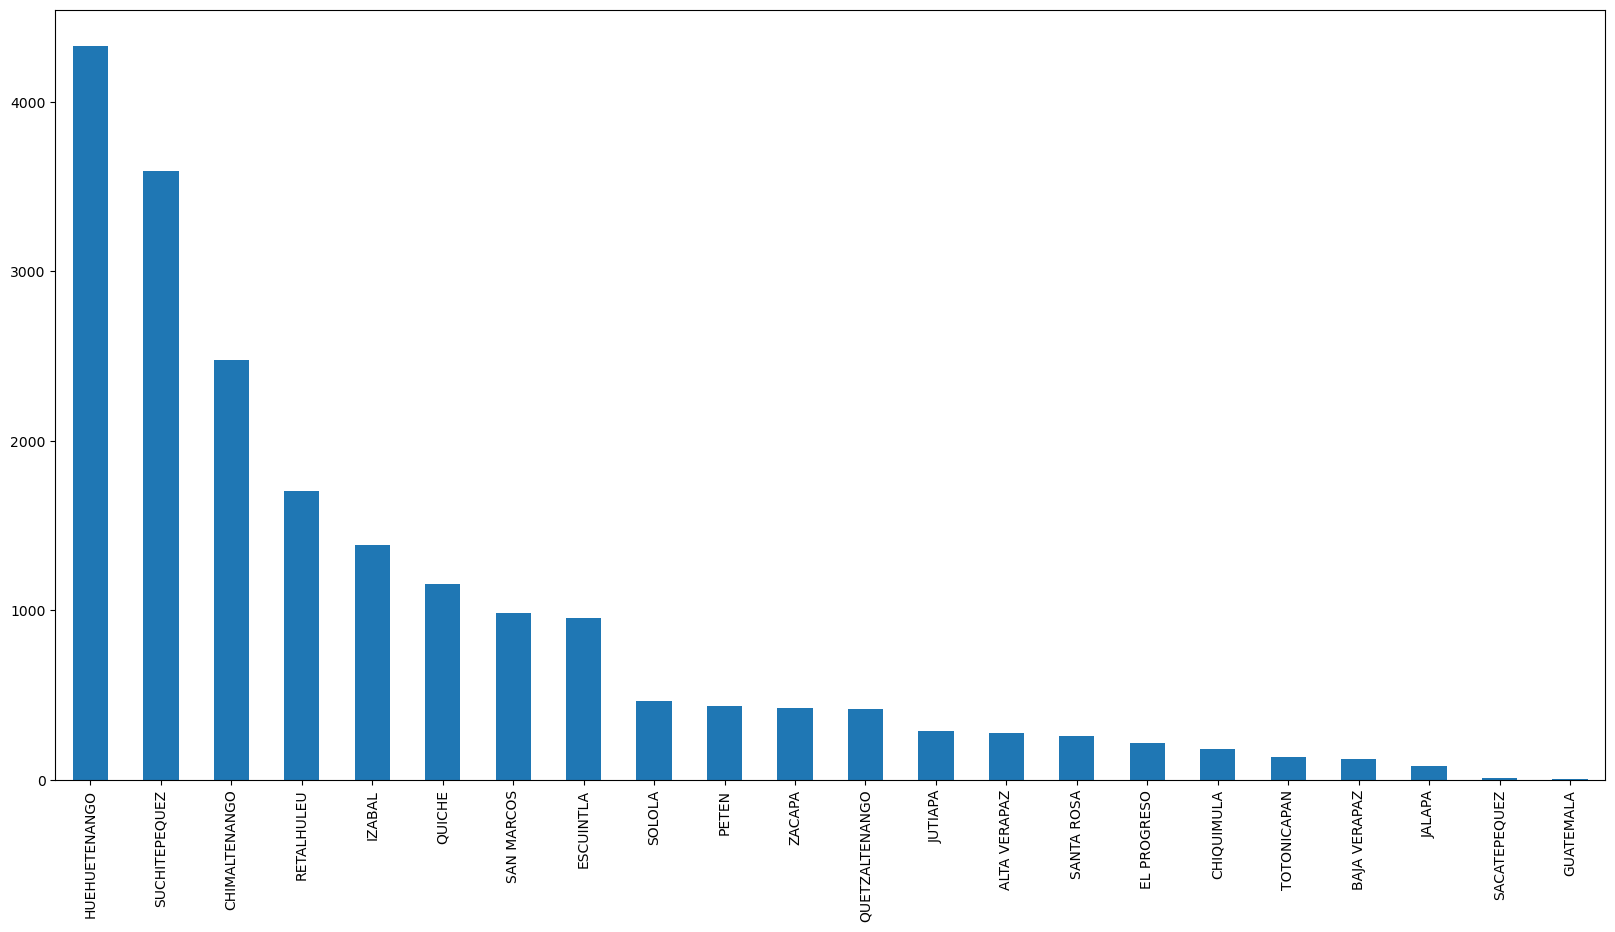

In [133]:
count_departamento=fraudes_df['DEPARTAMENTO'].value_counts()
print(count_departamento)
plt.figure(figsize=(20,10))
count_departamento.plot.bar()
plt.savefig('departamento.png',dpi=400)